In [1]:
import copy
import math
import scipy
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import Delaunay

In [2]:
RU_VECTORIZED_CORPUS = "/Users/mrseleznev/Desktop/Spot-the-bot/Russian/RuVectorizeCorpus/RuVectorizedCorpus.npy"

In [3]:
def delete_nans(corpus: list[dict]) -> list[dict]:
    result_corpus = []
    for text in tqdm(corpus):
        dict_ = {key: value for key, value in text.items() if value is not None}
        result_corpus.append(dict_)
    return result_corpus

In [4]:
ru_corpus = delete_nans(np.load(RU_VECTORIZED_CORPUS, allow_pickle=True).tolist())

100%|██████████████████████████████████| 12692/12692 [00:00<00:00, 16211.25it/s]


In [5]:
test = ru_corpus[:4]

In [6]:
def create_vertices(text: list[dict]) -> dict:
    vertices = dict()
    for text in tqdm(text):
        for word, vector in text.items():
            if word not in vertices.keys():
                vertices[word] = Node(vector[:2], set())
    return vertices

In [7]:
class Node:
    def __init__(self, vector: np.ndarray, neighbours: set):
        self.__vector = copy.deepcopy(vector)
        self.__neighbours = copy.deepcopy(neighbours)
        
    @property
    def vector(self):
        return self.__vector
    
    @vector.setter
    def vector(self, vector: np.ndarray):
        self.__vector = copy.deepcopy(vector)
        
    @property
    def neighbours(self):
        return self.__neighbours
    
    @neighbours.setter
    def neighbours(self, neighbours: set):
        self.__neighbours = copy.deepcopy(neighbours)

In [8]:
class Graph:
    def __init__(self, vertices: dict):
        self.__vertices = copy.deepcopy(vertices)
    
    @property
    def vertices(self):
        return self.__vertices
    
    @vertices.setter
    def vertices(self, vertices: dict):
        self.__vertices = copy.deepcopy(vertices)
    
    def get_vectors(self) -> list[list]:
        vectors = list()
        for node in self.vertices.values():
            vectors.append(node.vector.tolist())
        return vectors
    
    def get_words(self) -> list:
        words = list()
        for word in self.vertices.keys():
            words.append(word)
        return words
    
    def get_other_words(self, word: str) -> set:
        return set(self.vertices.keys()).difference(set([word]))
    
    def delete_edge(self, first_word: str, second_word: str):
        self.vertices[first_word].neighbours.difference_update(second_word)
        self.vertices[second_word].neighbours.difference_update(first_word)
        
    def add_edge(self, first_word: str, second_word: str):
        self.vertices[first_word].neighbours.update(set([second_word]))
        self.vertices[second_word].neighbours.update(set([first_word]))

    def reset_graph_neighbours(self):
        for node in self.vertices.values():
            node.neighbours.clear()
    
    def euclid_distance(self, first_word: str, second_word: str) -> np.float64:
        first_vertex = self.vertices[first_word].vector
        second_vertex = self.vertices[second_word].vector
        return np.linalg.norm(first_vertex - second_vertex)
    
    def get_knn(self, word: str, k: int) -> list:
        distance_dict = dict()
        other_words = self.get_other_words(word)
        for other_word in other_words:
            distance_dict[other_word] = self.euclid_distance(word, other_word)
        lambda_ = lambda item: item[1]
        words = [key for key, value in sorted(distance_dict.items(), key=lambda_)]
        return words[:k]
    
    def get_sphere_radius(self, word: str) -> float:
        return self.euclid_distance(word, self.get_knn(word, 1)[0])
        
    def in_sphere_check(self, first_word: str, second_word: str) -> bool:
        nearest_neighbour = get_knn(self, first_word, 1)
        radius = self.euclid_distance(first_word, nearest_neighbour)
        distance = self.euclid_distance(first_word, second_word)
        if radius < distance:
            return False
        return True

# Граф $\varepsilon$-окружности ($\varepsilon$-ball)

In [13]:
class EBall(Graph):
    def __init__(self, vertices: dict):
        super().__init__(vertices)
    
    def create_graph(self, epsilon: int):
        self.reset_graph_neighbours()
        for first_word in tqdm(self.vertices.keys()):
            other_words = self.get_other_words(first_word)
            for second_word in other_words:
                distance = self.euclid_distance(first_word, second_word)
                if distance < epsilon:
                    self.add_edge(first_word, second_word)

In [14]:
vertices = create_vertices(test)
ru_eball = EBall(vertices)

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1214.33it/s]


In [15]:
ru_eball.create_graph(0.09)

100%|████████████████████████████████████████| 220/220 [00:00<00:00, 474.35it/s]


# Граф Габриэля (GG)

In [16]:
class GG(Graph):
    def __init__(self,
                 vertices: dict,
                 triangles: list = list(),
                 delaunay: scipy.spatial.qhull.Delaunay = None):
        super().__init__(vertices)
        self.__triangles = copy.deepcopy(triangles)
        self.__delaunay = copy.deepcopy(delaunay)
        
    @property
    def triangles(self):
        return self.__triangles
    
    @triangles.setter
    def triangles(self, triangles: list):
        self.__triangles = copy.deepcopy(triangles)
        
    @property
    def delaunay(self):
        return self.__delaunay
    
    @delaunay.setter
    def delaunay(self, delaunay: scipy.spatial.qhull.Delaunay):
        self.__delaunay = copy.deepcopy(delaunay)

    def create_delaunay_graph(self):
        vectors = self.get_vectors()
        words = self.get_words()
        word_num_dict = {word: num for word, num in enumerate(words)}
        self.delaunay = Delaunay(np.array(vectors))
        delaunay_graph = self.delaunay.simplices.tolist()
        for triangle in delaunay_graph:
            triangle_words = set(map(word_num_dict.get, triangle))
            self.triangles.append(triangle_words)
            for word in triangle_words:
                new_neighbours = triangle_words.difference(set([word]))
                self.vertices[word].neighbours.update(new_neighbours)
    
    def in_edge_sphere(self, edge: tuple[str], neighbour: str) -> bool:
        edge_distance = self.euclid_distance(edge[0], edge[1])
        first_to_neighbour = self.euclid_distance(edge[0], neighbour)
        second_to_neighbour = self.euclid_distance(edge[1], neighbour)
        if edge_distance < math.sqrt(first_to_neighbour ** 2 + second_to_neighbour ** 2):
            return False
        return True
    
    def create_graph(self):
        self.reset_graph_neighbours()
        self.create_delaunay_graph()
        for triangle in self.triangles:
            edges = list(itertools.combinations(triangle, 2))
            for edge in edges:
                neighbours = triangle.difference(set(edge))
                for neighbour in neighbours:
                    if self.in_edge_sphere(edge, neighbour):
                        self.delete_edge(edge[0], edge[1])

In [17]:
gg = GG(vertices)
gg.create_graph()

In [26]:
gg_d = GG(vertices)
gg_d.create_delaunay_graph()

In [29]:
for word, node in gg.vertices.items():
    print(word, node.neighbours == gg_d.vertices[word].neighbours)

а True
д True
з True
о True
1 False
клеврет True
твой True
верный True
2 False
в True
искусство True
младенчество False
наставить True
к True
день False
всякий True
на True
ванька True
приезжать False
глупый True
и True
пьяный True
служить True
лакей True
из False
великий True
приветствовать True
бы False
смести True
что True
чорт True
не True
брат False
4 True
мой True
мать True
злой True
кручина True
отец True
же True
быть True
судьбина True
хоть True
человек True
хотеть True
грудь True
прижаться False
стыдно True
с False
бедный True
сирота True
обняться True
но True
бог True
дать True
молодой True
жена True
вольность True
милый True
несравненный True
найтись False
другой False
у True
семья True
степь True
широкий True
небо True
далекий False
воспитать True
кормить True
поить True
ласкать True
лес True
береза True
да True
сосна True
нестись True
ли False
конь True
отвечать True
бродить True
поздний True
порой True
светить True
луна True
летний True
призывать True
под True
тень True
м

In [27]:
gg.

In [28]:
gg_d.delaunay

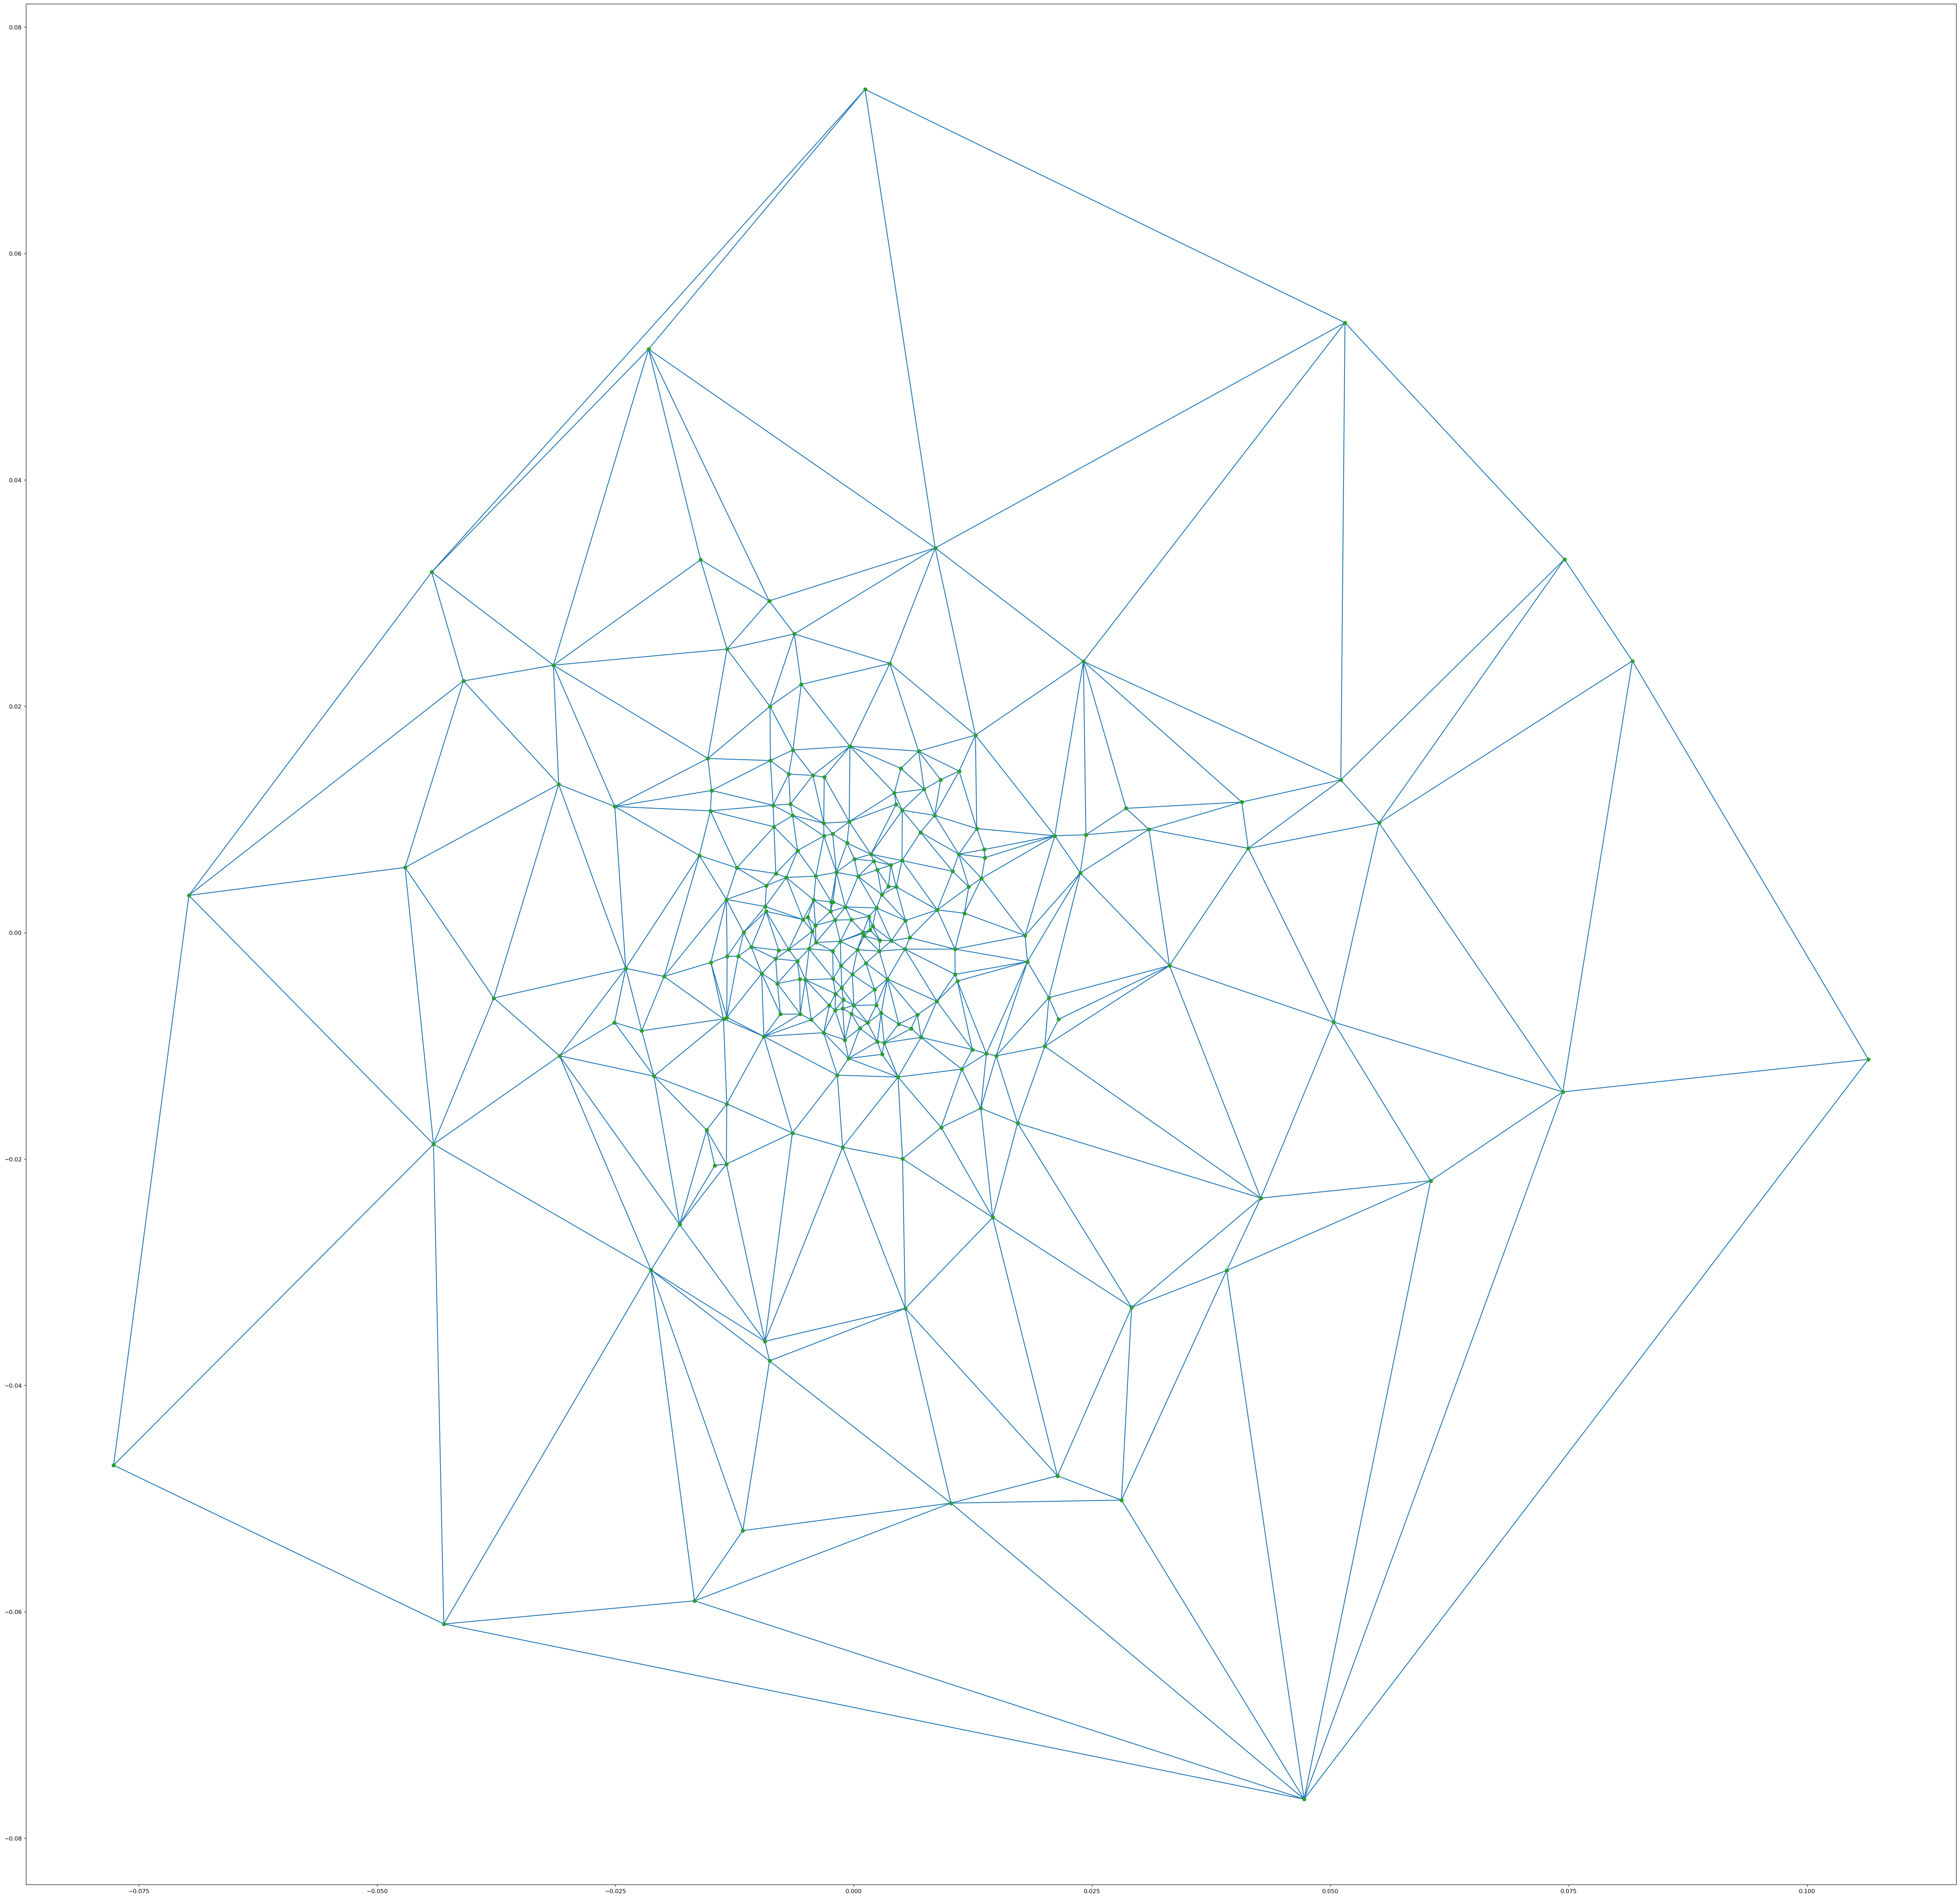

In [304]:
import matplotlib.pyplot as plt
plt.figure(figsize=(60, 60), dpi=120)
plt.triplot(points_arr[:,0], points_arr[:,1], tri.simplices)
plt.plot(points_arr[:,0], points_arr[:,1], 'o')
plt.show()

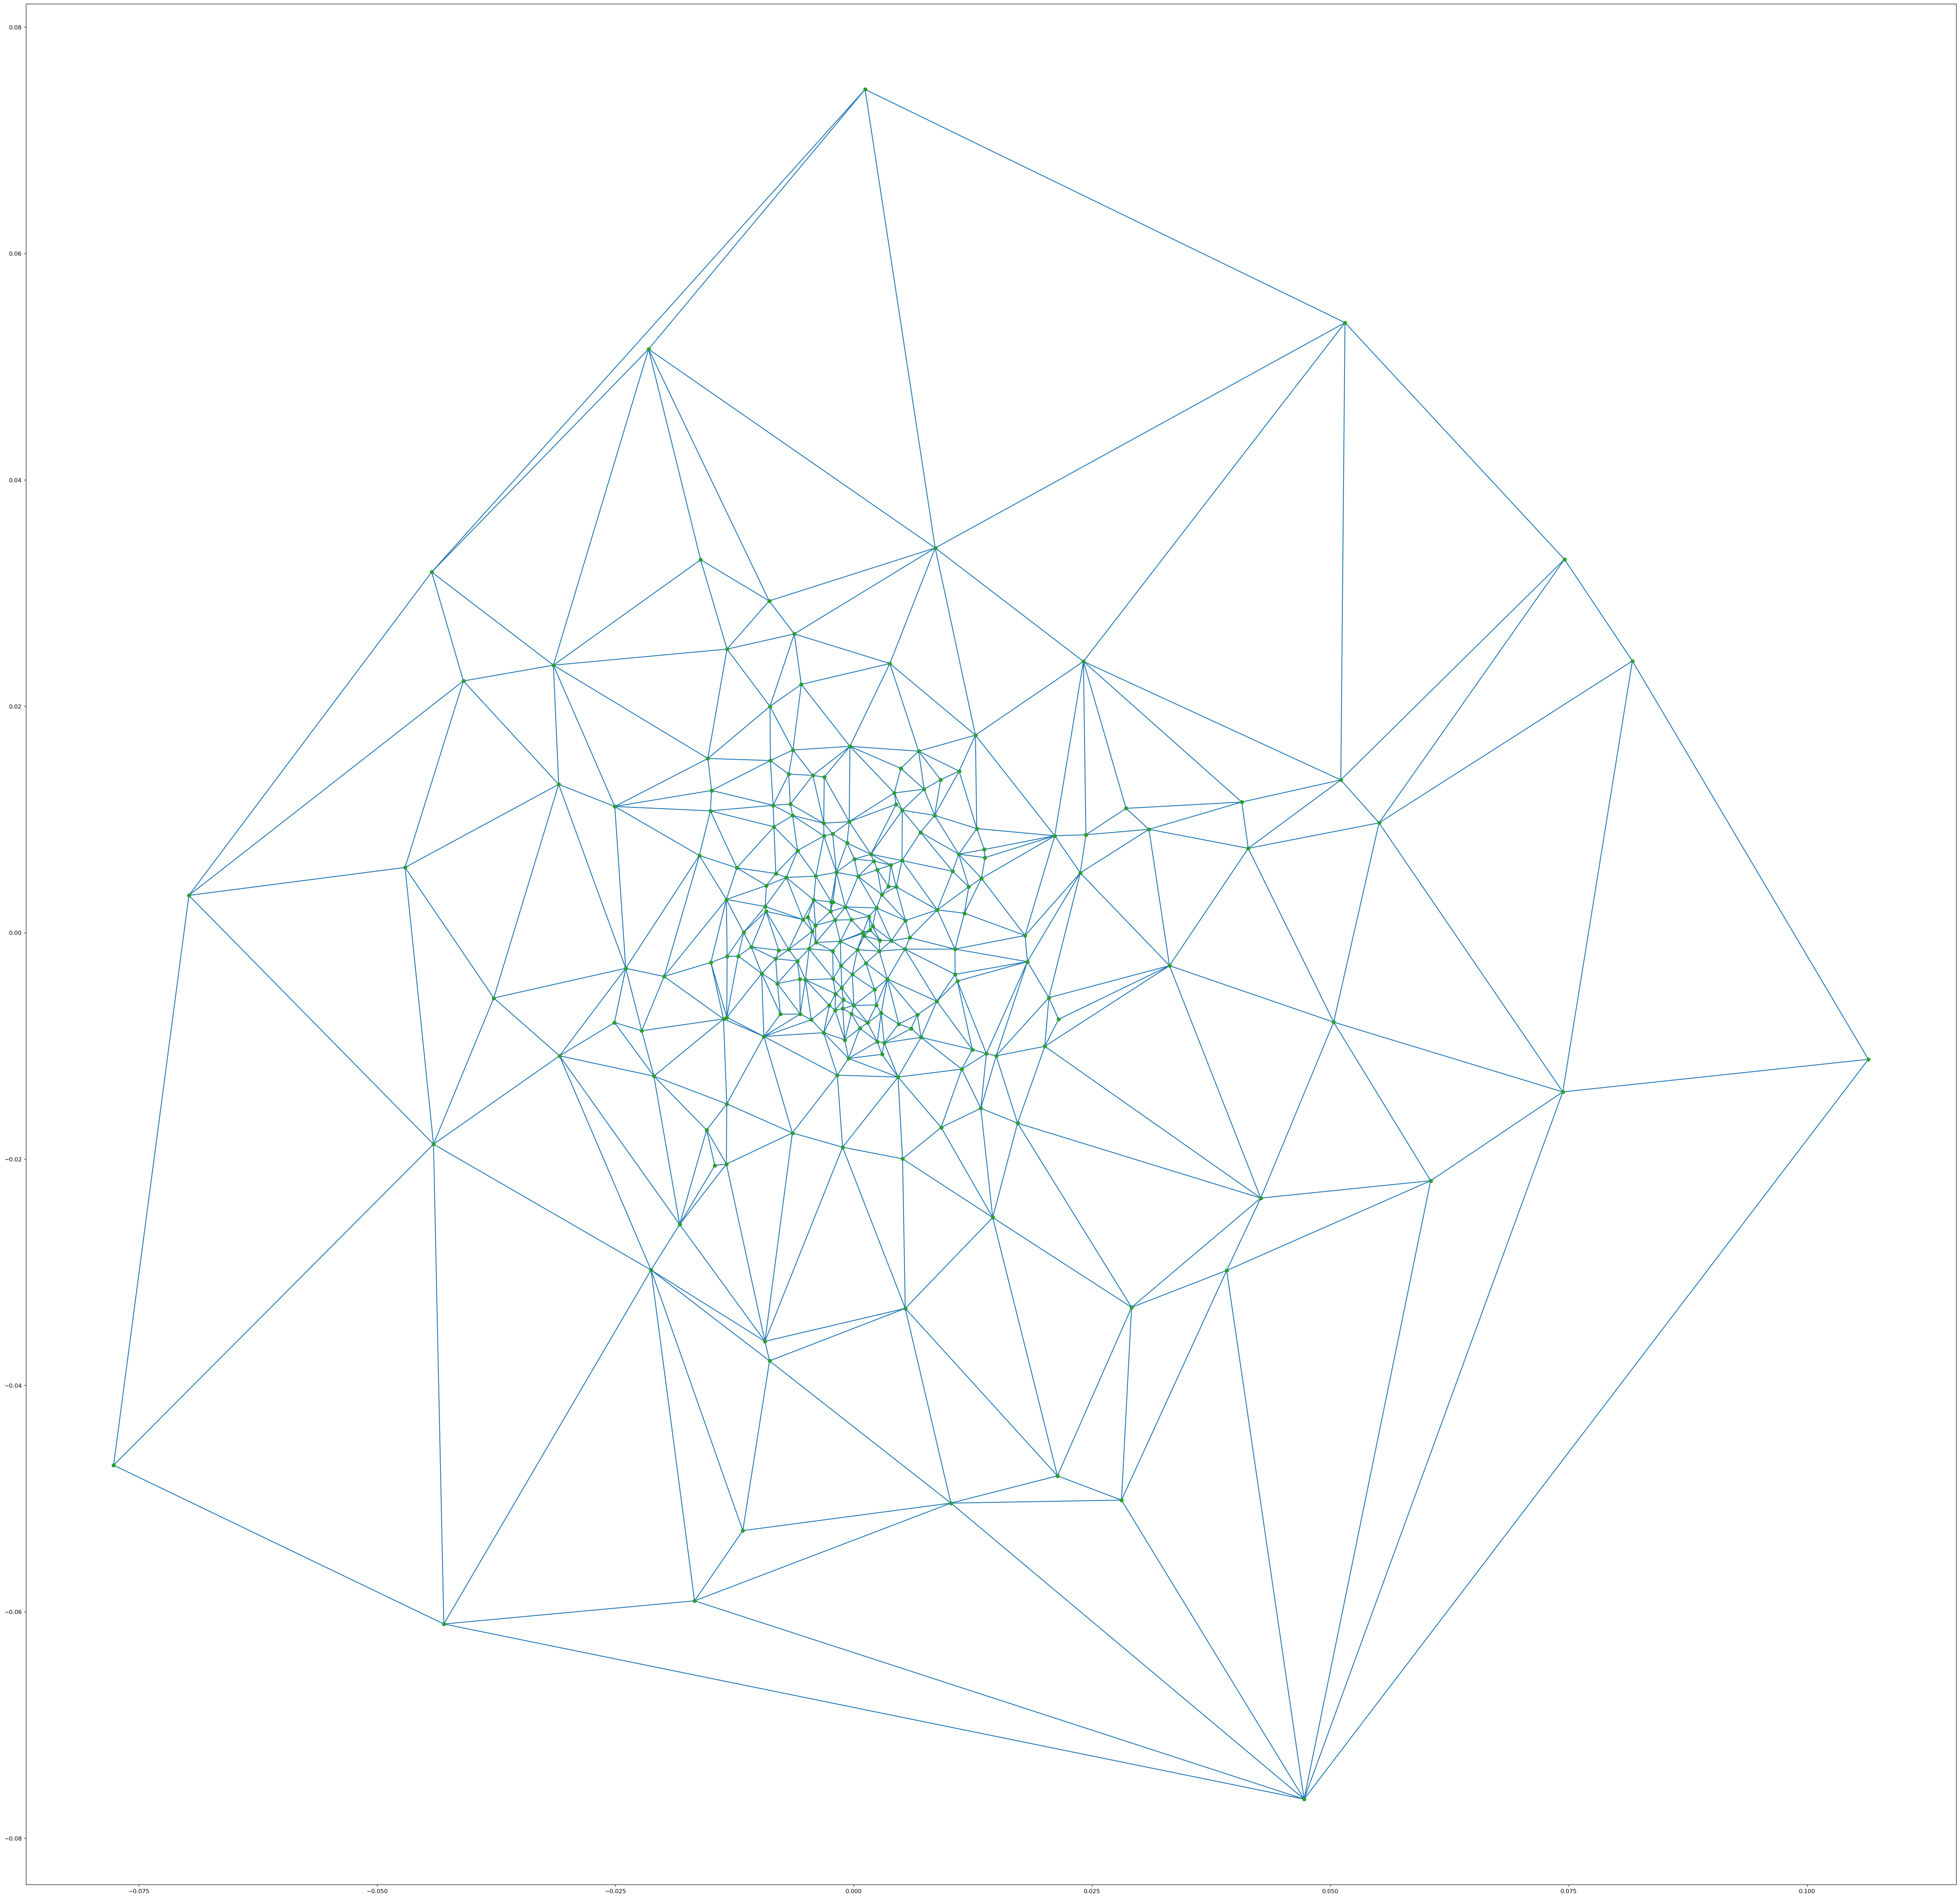

In [303]:
import matplotlib.pyplot as plt
plt.figure(figsize=(60, 60), dpi=120)
plt.triplot(points_arr[:,0], points_arr[:,1], tri.simplices)
plt.plot(points_arr[:,0], points_arr[:,1], 'o')
plt.show()

In [55]:
tri.neighbors

array([[ -1,   9,   6],
       [ 10,  -1,  18],
       [ -1,   3,  36],
       [  2,   8,  34],
       [  5,  -1,  32],
       [ 14,   4,  20],
       [  7,   0,  16],
       [  8,  -1,   6],
       [  3,   7,  39],
       [  0,  10,  11],
       [  9,   1,  12],
       [ 12,  15,   9],
       [ 17,  11,  10],
       [ -1,  14,  19],
       [ 13,   5,  24],
       [ 11,  43,  16],
       [  6,  15,  23],
       [ 55,  12,  18],
       [  1,  19,  17],
       [ 18,  13,  25],
       [  5,  28,  26],
       [ 31,  -1,  35],
       [ 51,  74,  49],
       [ 40,  16,  54],
       [ 14,  26,  25],
       [ 19,  24,  27],
       [ 24,  20,  27],
       [ 45,  25,  26],
       [ 20,  41,  29],
       [ 48,  44,  28],
       [136,  46,  33],
       [ 32,  21,  42],
       [ 33,   4,  31],
       [ 63,  32,  30],
       [  3,  77,  36],
       [ 21,  37,  79],
       [ 37,   2,  34],
       [ -1,  36,  35],
       [ 53,  50,  76],
       [ 90,   8,  40],
       [ 39,  23,  89],
       [ 28,  64

In [256]:
ru_gg.create_graph()

In [119]:
tri.simplices

array([[2, 3, 0],
       [3, 1, 0]], dtype=int32)

In [120]:
tri.points

array([[0. , 0. ],
       [0. , 1.1],
       [1. , 0. ],
       [1. , 1. ]])

In [33]:
res = tri.simplices

In [122]:
ru_gg = GG(vertices)

In [123]:
ru_gg.vertices['а'].vector.tolist()

[0.0021725040552750246,
 -0.005030105269743438,
 -0.004235298365319906,
 -0.000585829134855019,
 -0.00598034202880371,
 0.004831506481237,
 -0.010289995775104113,
 -0.0029990157859896304]

# Граф влияния (IG)

In [18]:
class IG(Graph):
    def __init__(self, vertices: dict):
        super().__init__(vertices)
    
    
    def create_graph(self):
        self.reset_graph_neighbours()
        for first_word in tqdm(self.vertices.keys()):
            other_words = self.get_other_words(first_word)
            first_radius = self.get_sphere_radius(first_word)
            for second_word in other_words:
                second_radius = self.get_sphere_radius(second_word)
                distance = self.euclid_distance(first_word, second_word)
                if distance <= first_radius + second_radius:
                    self.add_edge(first_word, second_word)

In [19]:
ig = IG(vertices)

In [20]:
ig.create_graph()

100%|█████████████████████████████████████████| 220/220 [01:11<00:00,  3.09it/s]


In [26]:
ig.vertices['наставить'].neighbours

{'1', 'веселить', 'голос', 'наружный', 'спроситься'}

# Граф $k$-ближайших соседей (NNG)

In [28]:
class NNG(Graph):
    def __init__(self, vertices: dict):
        super().__init__(vertices)
    
    def create_graph(self, k: int):
        self.reset_graph_neighbours()
        for word in tqdm(self.vertices.keys()):
            knn_list = self.get_knn(word, k)
            for neighbour in knn_list:
                self.add_edge(word, neighbour)

In [29]:
nng = NNG(vertices)

In [30]:
nng.create_graph(2)

100%|████████████████████████████████████████| 220/220 [00:00<00:00, 564.08it/s]


# Граф относительного соседства (RNG)

In [ ]:
class RNG(Graph):
    def __init__(self, vertices: dict):
        super().__init__(vertices)
    
    def create_graph(self):
        pass

In [ ]:
vertices = dict()
for text in tqdm(test):
    for word, vector in text.items():
        neighbours = set(text.keys()).difference(set([word]))
        if word not in vertices.keys():
            vertices[word] = Node(vector, neighbours)
        else:
            vertices[word].neighbours.update(neighbours)
ru_graph = Graph(vertices)

In [9]:
ru_graph = Graph(vertices)

In [14]:
ru_graph.get_knn('мать', 1)

['спеша']

# Save Graph

In [15]:
with open("vertices.pkl", "wb") as f:
    pickle.dump(vertices, f)

In [41]:
triangle_words

{'0',
 '1',
 '2',
 '4',
 'а',
 'бедный',
 'береза',
 'бесценный',
 'блаженство',
 'бог',
 'брат',
 'бродить',
 'будто',
 'бы',
 'былой',
 'быть',
 'в',
 'ванька',
 'ваш',
 'великий',
 'верный',
 'веселить',
 'взор',
 'взять',
 'видеть',
 'власть',
 'вновь',
 'вольность',
 'воспитать',
 'встречать',
 'всякий',
 'глупый',
 'гнездо',
 'говорить',
 'год',
 'голова',
 'голос',
 'грудь',
 'гряда',
 'д',
 'да',
 'далекий',
 'дать',
 'день',
 'для',
 'другой',
 'душа',
 'его',
 'ее',
 'еще',
 'жать',
 'же',
 'жена',
 'жертвовать',
 'з',
 'здесь',
 'земля',
 'зима',
 'злой',
 'и',
 'из',
 'издать',
 'искусство',
 'к',
 'как',
 'кивать',
 'клеврет',
 'конь',
 'кормить',
 'красота',
 'кручина',
 'лакей',
 'ласкать',
 'лес',
 'летний',
 'летучий',
 'ли',
 'лиловый',
 'лишь',
 'лобзание',
 'лобзать',
 'луна',
 'ль',
 'любить',
 'любовь',
 'мать',
 'махать',
 'мгновение',
 'милый',
 'мир',
 'младенчество',
 'могила',
 'могильный',
 'мой',
 'молодой',
 'молчание',
 'мочь',
 'мрак',
 'мыслить',
 'на',

In [ ]:
# vertices = dict()
# for text in tqdm(test):
#     for word, vector in text.items():
#         neighbours = set(text.keys()).difference(set([word]))
#         if word not in vertices.keys():
#             vertices[word] = Node(vector, neighbours)
#         else:
#             vertices[word].neighbours.update(neighbours)
# ru_graph = Graph(vertices)